# Spooky Author Identification #

### The aim of this project is to identify an author of spooky stories from a sentence written by them. The data for this is downloaded from here: https://www.kaggle.com/competitions/spooky-author-identification/data

### This data contains 19000+ sentences written by three authors - Edgar Allan Poe (EAP), H P Lovecroft (HPL) and Mary Shelley (MWS).

#### We will start by importing the modules and loading the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('../../old/CS 250 Data/Spooky/train.csv')
data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


#### Next, check to see if the numbers in different classes are balanced

In [4]:
data.author.value_counts()


EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

#### There is a slight imbalance in favor of EAP, but we will let that be for the time being since it isn't too bad. Since the data is just one column of X (sentences) and one column of Y (labels), we separate these into two numpy arrays.

In [5]:
author = np.array(data.author)
text = np.array(data.text)

#### Next, we split both X and Y into training and test sets in an 80%-20% ratio.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text,author,test_size=0.2)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(15663,) (3916,) (15663,) (3916,)


# We can't, however, use these sentences directly as X!!!

### They are all different lengths, and we can't compare them with each other. So we need to build a vocabulary.

#### To do that, we need to make a list of all words used in all the sentences of the training set.  So I use a dictionary to do that. I also store their frequencies, just in case we need to know how common a word is.

#### We also write a helper function, "strip", that takes in a word, strips all non-alphabetic characters from it (such as following commas and full stops), converts it to lowercase, and returns it. This is to prevent different versions of the same word in our vocabulary.

In [7]:
def strip(word):
    ans = ''
    for char in word:
        if 'a' <= char.lower() <= 'z':
            ans += char.lower()
    return ans

vocabulary = {}
for line in X_train:
    words = line.split()
    for piece in words:
        word = strip(piece)
        if word in vocabulary:
            vocabulary[word] += 1
        else:
            vocabulary[word] = 1

print('Total no. of words =',len(vocabulary))

Total no. of words = 23214


#### Our vocab has 23,000+ words. We will now represent each sentence in train and test by a histogram of these words, so each sentence is represented by an equal sized (but very sparse) vector.

#### 23,000 is a little too much for the vector size, so we will discard all words that appear only once in the whole vocabulary.

In [8]:
## Sort the vocab by descending word frequency (not needed, just for curiosity)
sorted_counts = sorted(vocabulary.items(), key = lambda kv: kv[1], reverse = True)
sorted_vocab = dict(sorted_counts)

## Build final vocab discarding words with frequency 1. We don't need the frequencies after this point.
final_vocab = []
for i in sorted_vocab.keys():  
    if sorted_vocab[i] > 1:
        final_vocab.append(i)

        
print('Number of repeated words =',len(final_vocab))


Number of repeated words = 14249


In [9]:
sorted_vocab

{'the': 28564,
 'of': 16782,
 'and': 14372,
 'to': 10289,
 'i': 8676,
 'a': 8567,
 'in': 7532,
 'was': 5303,
 'that': 5127,
 'my': 4395,
 'it': 3906,
 'with': 3504,
 'had': 3503,
 'he': 3486,
 'his': 3255,
 'as': 3061,
 'for': 2802,
 'which': 2701,
 'but': 2673,
 'not': 2616,
 'at': 2561,
 'me': 2421,
 'from': 2321,
 'by': 2318,
 'is': 2164,
 'this': 2121,
 'on': 1986,
 'be': 1927,
 'her': 1868,
 'were': 1757,
 'have': 1677,
 'all': 1626,
 'you': 1568,
 'an': 1477,
 'we': 1449,
 'or': 1379,
 'no': 1367,
 'one': 1259,
 'so': 1253,
 'him': 1243,
 'when': 1232,
 'been': 1150,
 'upon': 1130,
 'they': 1108,
 'its': 1079,
 'there': 1055,
 'she': 1041,
 'could': 1031,
 'would': 1006,
 'more': 968,
 'their': 926,
 'now': 923,
 'what': 877,
 'some': 843,
 'our': 804,
 'are': 793,
 'into': 780,
 'who': 761,
 'than': 760,
 'will': 742,
 'very': 741,
 'if': 736,
 'only': 707,
 'them': 704,
 'then': 675,
 'before': 651,
 'these': 642,
 'up': 639,
 'about': 619,
 'man': 576,
 'time': 574,
 'even': 5

#### So the size of our vocabulary is 14362. Next, we will convert our whole training (and test) sets into extremely sparse histograms. 

In [10]:
trainData = np.zeros((X_train.shape[0],len(final_vocab)),'uint16')
for i in range(trainData.shape[0]):
    words = X_train[i].split()
    for j in range(len(words)):
        token = strip(words[j])
        if token in final_vocab:
            trainData[i,final_vocab.index(token)] += 1
        
testData = np.zeros((X_test.shape[0],len(final_vocab)),'uint16')
for i in range(testData.shape[0]):
    words = X_test[i].split()
    for j in range(len(words)):
        token = strip(words[j])
        if token in final_vocab:
            testData[i,final_vocab.index(token)] += 1
        


In [11]:
print('Size of training data:',trainData.shape)
print('Size of test data:',testData.shape)

Size of training data: (15663, 14249)
Size of test data: (3916, 14249)


### Now we will try a few classification methods on this data - Logistic Regression, SVM and Random Forest

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor

print('Training Logistic Regressor',end='...')
model_LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial',max_iter=1000)
model_LR.fit(trainData, y_train)
print('done!')

print('Training Support Vector Machine',end='...')
model_SVM = svm.LinearSVC(max_iter=5000)
model_SVM.fit(trainData, y_train)
print('done!')

# Random forest needs numerical labels - so converting string labels to numbers
labelStrings = ['EAP' , 'HPL' , 'MWS']
trainLabels = []
testLabels = []
for label in y_train:
    trainLabels.append(labelStrings.index(label))
for label in y_test:
    testLabels.append(labelStrings.index(label))

print('Training Random Forest Regressor',end='...')
model_RF = RandomForestRegressor(n_estimators= 10, random_state=42)
model_RF.fit(trainData, trainLabels)
print('done!')



Training Logistic Regressor...done!
Training Support Vector Machine...done!
Training Random Forest Regressor...

KeyboardInterrupt: 

In [ ]:
#Run models on test data
print('Test data performance:\n')
print('Logistic Regressor score :',model_LR.score(testData, y_test))
print('SVM score :',model_SVM.score(testData, y_test))
print('Random Forest score :',model_RF.score(testData, testLabels))

#### Just to find out how much the models are learning, we also check the performances on the training data

In [49]:
#Run models on training data
print('Training data performance:\n')
print('Logistic Regressor score :',model_LR.score(trainData, y_train))
print('SVM score :',model_SVM.score(trainData, y_train))
print('Random Forest score :',model_RF.score(trainData, trainLabels))

Training data performance:

Logistic Regressor score : 0.9784843261188789
SVM score : 0.9933601481197727
Random Forest score : 0.8683445027371611


#### We find the Logistic Regressor gives the best score, whereas the Random Forest has severe overfitting.

#### We use this best model to further create a confusion matrix

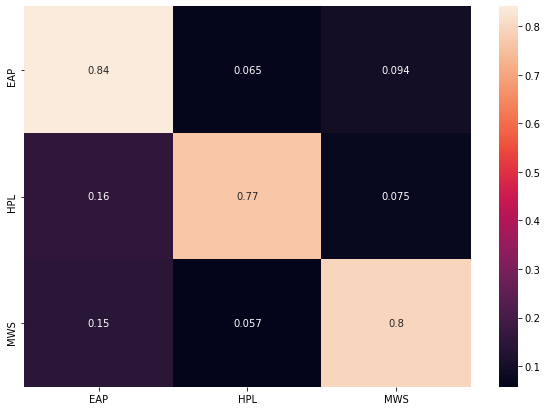

In [50]:
#Visualize performance by Normalized confusion matrix
import seaborn as sn
numClasses = 3
classes = ['EAP','HPL','MWS']

conf = np.zeros([numClasses,numClasses])
guesses = model_LR.predict(testData)

for s in range(testData.shape[0]):
    real = classes.index(y_test[s])
    guess = classes.index(guesses[s])
    conf[real,guess] = conf[real,guess] + 1
 
rowsums = np.sum(conf,1)
rowsums = np.reshape(rowsums,[numClasses,1])
rowsums = np.repeat(rowsums,numClasses, axis = 1)
conf = conf / rowsums
df_cm = pd.DataFrame(conf, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

### Our vectors are terrible... extremely sparse and huge. We will try to reduce their dimensionality using PCA and see how that affects the classification scores

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler=StandardScaler()
normtrain = scaler.fit_transform(trainData)
normtest = scaler.fit_transform(testData)

pca = PCA(n_components=500,whiten=True)
lowtrain = pca.fit_transform(normtrain)
lowtest = pca.transform(normtest)

print('Training and test data shape after dimensionality reduction:',lowtrain.shape,lowtest.shape)

In [52]:
print('Training Logistic Regressor',end='...')
model_LR2 = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial',max_iter=1000)
model_LR2.fit(lowtrain, y_train)
print('done!')

print('Training Support Vector Machine',end='...')
model_SVM2 = svm.LinearSVC(max_iter=5000)
model_SVM2.fit(lowtrain, y_train)
print('done!')

print('Training Random Forest Regressor',end='...')
model_RF2 = RandomForestRegressor(n_estimators= 10, random_state=42)
model_RF2.fit(lowtrain, trainLabels)
print('done!')



Training Logistic Regressor...done!
Training Support Vector Machine...

e:\Users\sbane\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


done!
Training Random Forest Regressor...done!


In [53]:
#Run models on test data
print('Test data performance:\n')
print('Logistic Regressor score :',model_LR2.score(lowtest, y_test))
print('SVM score :',model_SVM2.score(lowtest, y_test))
print('Random Forest score :',model_RF2.score(lowtest, testLabels))

Test data performance:

Logistic Regressor score : 0.7957099080694586
SVM score : 0.7908580183861083
Random Forest score : 0.34359533167020195


In [54]:
#Run models on training data
print('Training data performance:\n')
print('Logistic Regressor score :',model_LR2.score(lowtrain, y_train))
print('SVM score :',model_SVM2.score(lowtrain, y_train))
print('Random Forest score :',model_RF2.score(lowtrain, trainLabels))

Training data performance:

Logistic Regressor score : 0.8326629636723488
SVM score : 0.8296622613803231
Random Forest score : 0.8758245994557877


<AxesSubplot:>

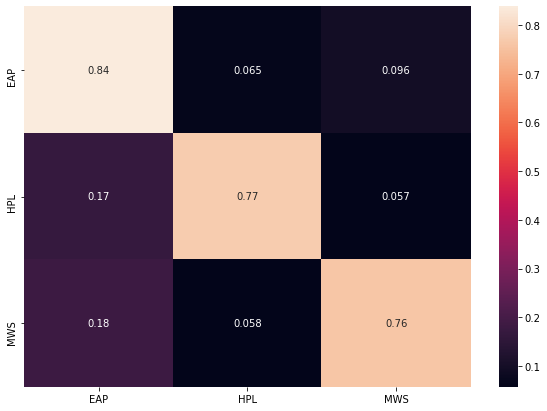

In [55]:
#Visualize performance by Normalized confusion matrix
import seaborn as sn
numClasses = 3
classes = ['EAP','HPL','MWS']

conf = np.zeros([numClasses,numClasses])
guesses = model_LR2.predict(lowtest)

for s in range(lowtest.shape[0]):
    real = classes.index(y_test[s])
    guess = classes.index(guesses[s])
    conf[real,guess] = conf[real,guess] + 1
 
rowsums = np.sum(conf,1)
rowsums = np.reshape(rowsums,[numClasses,1])
rowsums = np.repeat(rowsums,numClasses, axis = 1)
conf = conf / rowsums
df_cm = pd.DataFrame(conf, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# NN and K-NN Retrieval

#### We use the sparse vectors here to fetch closest sentences to a (randomly chosen) query sentence. We use the nearest matches by Manhattan distance here. Manhattan distance has been shown to work better than Euclidean distance for comparing vectors that are histograms.

In [15]:
queryNum = np.random.randint(trainData.shape[0]) # 4651
query = X_train[queryNum]
print('Query sentence:',query)


Query sentence: All attempts at logical inquiry resulted, indeed, in leaving me more sceptical than before.


In [16]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

queryVector = trainData[queryNum,:]
queryVector = queryVector.reshape(1, -1)
dists1 = manhattan_distances(queryVector,trainData)
sortedIdx = np.argsort(dists1)
sortedIdx = np.squeeze(sortedIdx)

for i in range(10):
    sentence = X_train[sortedIdx[i]]      
    label = y_train[sortedIdx[i]]
    print(label +':\t' + sentence)

EAP:	All attempts at logical inquiry resulted, indeed, in leaving me more sceptical than before.
EAP:	Rousseau Nouvelle Heloise.
EAP:	Emicant Trabes quos docos vocant.
MWS:	Shakspeare's Sonnets.
MWS:	Shakespeare's Sonnets.
EAP:	Pundit is in ecstacies.
EAP:	All efforts proved in vain.
EAP:	Indeed, every appearance warranted me in apprehending a Simoom.
EAP:	"Indeed;" repeated the vassal.
EAP:	" Odenheimer, restaurateur.


#### As can be seen, the retrieved nearest neighbors only have a few words common with the query. Also, there words are often common words like "is" or "the". Now let's do the retrieval using the PCA dimensionality reduced vectors.


In [17]:
queryVector = lowtrain[queryNum,:]
queryVector = queryVector.reshape(1, -1)
dists2 = euclidean_distances(queryVector,lowtrain)
sortedIdx = np.argsort(dists2)
sortedIdx = np.squeeze(sortedIdx)

for i in range(10):
    sentence = X_train[sortedIdx[i]]      
    label = y_train[sortedIdx[i]]
    print(label +':\t' + sentence)

NameError: name 'lowtrain' is not defined

In [59]:
sorted_vocab

{'the': 28350,
 'of': 16739,
 'and': 14252,
 'to': 10224,
 'i': 8650,
 'a': 8515,
 'in': 7564,
 'was': 5296,
 'that': 5101,
 'my': 4305,
 'it': 3873,
 'he': 3477,
 'had': 3475,
 'with': 3470,
 'his': 3282,
 'as': 3053,
 'for': 2808,
 'which': 2693,
 'but': 2679,
 'not': 2624,
 'at': 2596,
 'me': 2351,
 'by': 2298,
 'from': 2292,
 'is': 2217,
 'this': 2086,
 'on': 1995,
 'be': 1930,
 'her': 1827,
 'were': 1739,
 'have': 1693,
 'all': 1601,
 'you': 1549,
 'an': 1479,
 'we': 1418,
 'or': 1396,
 'no': 1349,
 'one': 1291,
 'so': 1266,
 'him': 1215,
 'when': 1200,
 'upon': 1151,
 'been': 1146,
 'they': 1134,
 'could': 1073,
 'there': 1058,
 'its': 1032,
 'she': 1026,
 'would': 993,
 'more': 951,
 'their': 929,
 'now': 928,
 'what': 868,
 'some': 835,
 'our': 833,
 'are': 797,
 'into': 769,
 'than': 763,
 'who': 742,
 'will': 740,
 'very': 735,
 'if': 721,
 'them': 711,
 'only': 702,
 'then': 668,
 'up': 640,
 'these': 620,
 'about': 613,
 'before': 605,
 'any': 601,
 'time': 586,
 'man': 580